# Bayesian Model Comparison on Gaussian Processes

This notebook demonstrates how to perform Bayesian model comparison with the `compass` package on the example of Gaussian processes.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,2,4,5,6,7,8,9"

In [2]:
from compass import ScoreBasedInferenceModel as SBIm
from compass import ModelTransfuser as MTf

In [3]:
import torch

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Hypothesis 1
$$ \begin{align*}
    \theta_1 &\sim \mathcal{N}(0, 3^2) \\
    x_1 &\sim \mathcal{N}(2 \cdot \sin(\theta_1), 0.5^2) \\
    x_2 &\sim \mathcal{N}(x_2; 0.1 \cdot \theta_1^2, (0.5 \cdot |x_1|)^2)
\end{align*} $$

In [4]:
def gen_data_hyp1(int):
    theta1 = 3 * torch.randn(int)
    x1 = 2 * torch.sin(theta1) + torch.randn(int) * 0.5
    x2 = 0.1 * theta1**2 + 0.5*torch.abs(x1) * torch.randn(int)

    return theta1.unsqueeze(1), torch.stack([x1, x2],dim=1)

In [5]:
theta1, x1 = gen_data_hyp1(100_000)
val_theta1, val_x1 = gen_data_hyp1(1_000)

nodes_max = theta1.shape[1] + x1.shape[1]

## Hypothesis 2
$$ \begin{align*}
    \theta_1 &\sim \mathcal{N}(0, 3^2) \\
    x_1 &\sim \mathcal{N}(2 \cdot \cos(\theta_1), 0.5^2) \\
    x_2 &\sim \mathcal{N}(x_2; 0.1 \cdot \theta_1^2, (0.5 \cdot |x_1|)^2)
\end{align*} $$

In [6]:
def gen_data_hyp2(int):
    theta1 = 3 * torch.randn(int)
    x1 = 2 * torch.cos(theta1) + torch.randn(int) * 0.5
    x2 = 0.1 * theta1**2 + 0.5*torch.abs(x1) * torch.randn(int)

    return theta1.unsqueeze(1), torch.stack([x1, x2],dim=1)

In [7]:
theta2, x2 = gen_data_hyp2(100_000)
val_theta2, val_x2 = gen_data_hyp2(1_000)

## Hypothesis 3
$$ \begin{align*}
    \theta_1 &\sim \mathcal{N}(0, 3^2) \\
    x_1 &\sim \mathcal{N}(2 \cdot \sin(\theta_1), 1^2) \\
    x_2 &\sim \mathcal{N}(x_2; 0.1\cdot\theta_1^2, (1 \cdot |x_1|)^2)
\end{align*} $$

In [8]:
def gen_data_hyp3(int):
    theta1 = 3 * torch.randn(int)
    x1 = 2 * torch.sin(theta1) + torch.randn(int) * 1
    x2 = 0.1*theta1**2 + 1*torch.abs(x1) * torch.randn(int)

    return theta1.unsqueeze(1), torch.stack([x1, x2],dim=1)

In [9]:
theta3, x3 = gen_data_hyp3(100_000)
val_theta3, val_x3 = gen_data_hyp3(1_000)

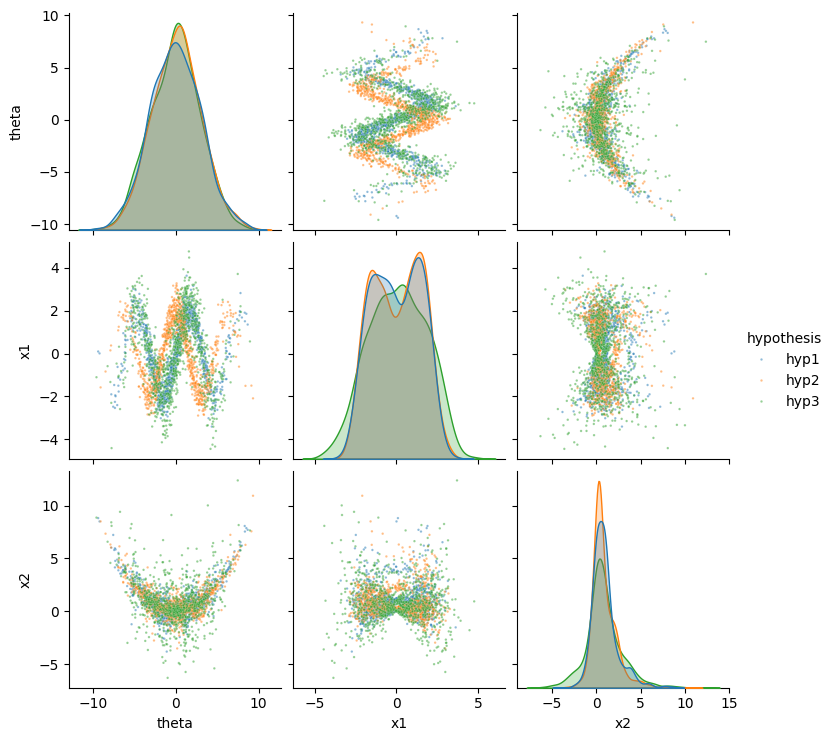

In [10]:
df1 = pd.DataFrame(torch.concatenate([val_theta1, val_x1], dim=1).numpy(), columns=['theta', 'x1', 'x2'])
df2 = pd.DataFrame(torch.concatenate([val_theta2, val_x2], dim=1).numpy(), columns=['theta', 'x1', 'x2'])
df3 = pd.DataFrame(torch.concatenate([val_theta3, val_x3], dim=1).numpy(), columns=['theta', 'x1', 'x2'])

df1["hypothesis"] = "hyp1"
df2["hypothesis"] = "hyp2"
df3["hypothesis"] = "hyp3"

combined_df = pd.concat([df1, df2, df3], axis=0)

sns.pairplot(combined_df, diag_kind='kde', hue='hypothesis', plot_kws=dict(alpha=0.5, s=3))
plt.show()

In [11]:
mtf = MTf(path="data/tutorial_Gaussians")

In [12]:
mtf.add_data("Hypothesis 1", theta1, x1, val_theta1, val_x1)
mtf.add_data("Hypothesis 2", theta2, x2, val_theta2, val_x2)
mtf.add_data("Hypothesis 3", theta3, x3, val_theta3, val_x3)

Data added to model Hypothesis 1
Data added to model Hypothesis 2
Data added to model Hypothesis 3


In [13]:
mtf.init_models(sde_type="vesde", sigma=1.6, depth=4, num_heads=24, hidden_size=168, mlp_ratio=5)

Models initialized: ['Hypothesis 1', 'Hypothesis 2', 'Hypothesis 3']


In [14]:
sum(p.numel() for p in mtf.models_dict["Hypothesis 1"].parameters())

5389528

In [15]:
mtf.train_models(verbose=False, batch_size=256)

Model Hypothesis 1 trained
Model Hypothesis 2 trained
Model Hypothesis 3 trained


In [16]:
# sbim1 = SBIm.load("tests/Hypothesis 1_checkpoint.pt", device="cuda")
# sbim2 = SBIm.load("tests/Hypothesis 2_checkpoint.pt", device="cuda")
# sbim3 = SBIm.load("tests/Hypothesis 3_checkpoint.pt", device="cuda")

# mtf.add_model("Hypothesis 1", sbim1)
# mtf.add_model("Hypothesis 2", sbim2)
# mtf.add_model("Hypothesis 3", sbim3)

In [17]:
# Create test data
test_theta1, test_x1 = gen_data_hyp1(100)

# Compare models on test data
mtf.compare(x=test_x1, device="cuda", timesteps=100, method="dpm", order=1)

Probabilities of the models after 100 observations:
Hypothesis 1:   0.00 %
Hypothesis 2:   0.00 %
Hypothesis 3: 100.00 %

Model Hypothesis 3 fits the data best with a relative support of 100.0% among the considered models and could reject the null hypothesis decisively.


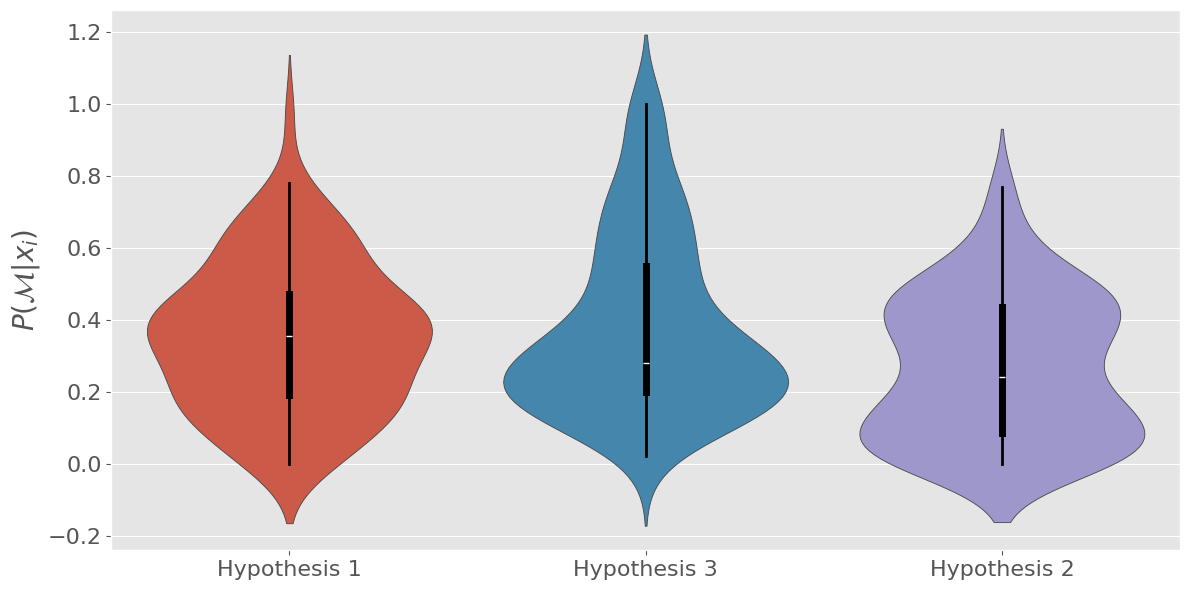

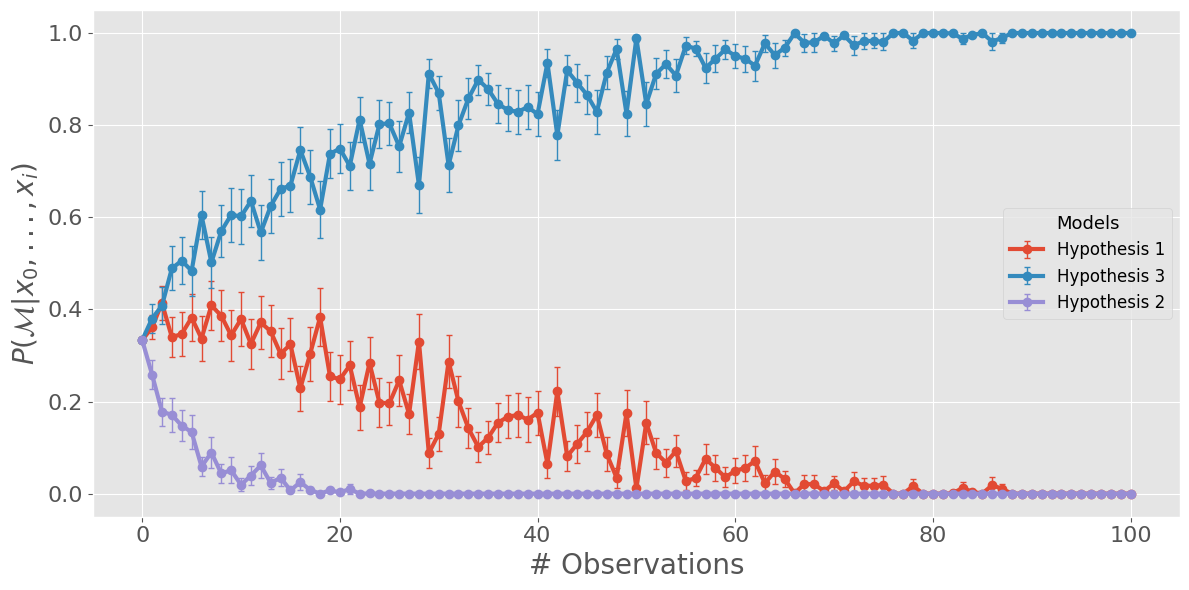

In [18]:
mtf.plot_comparison()

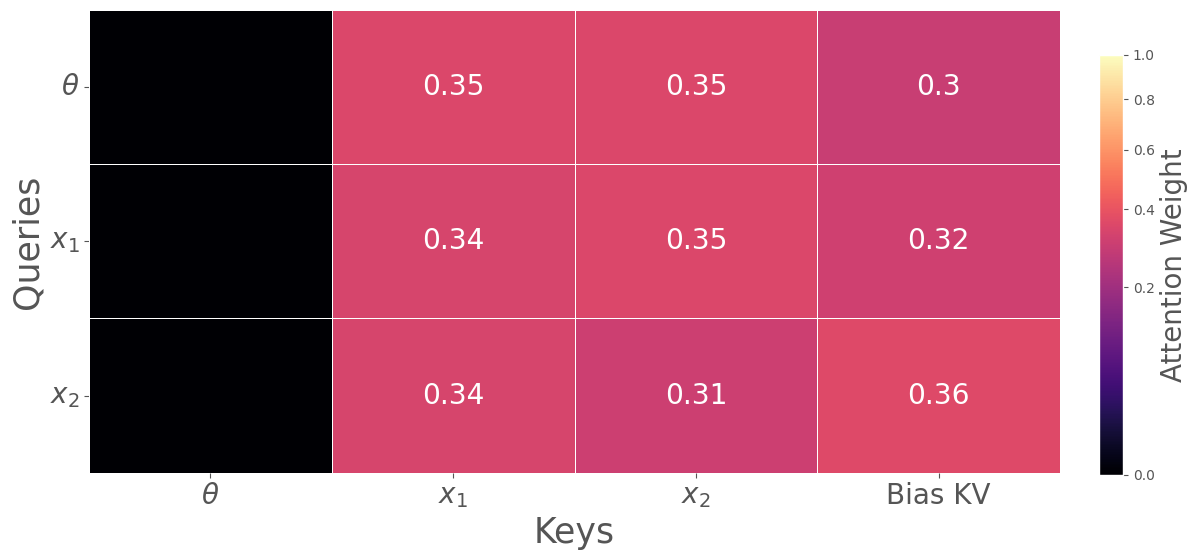

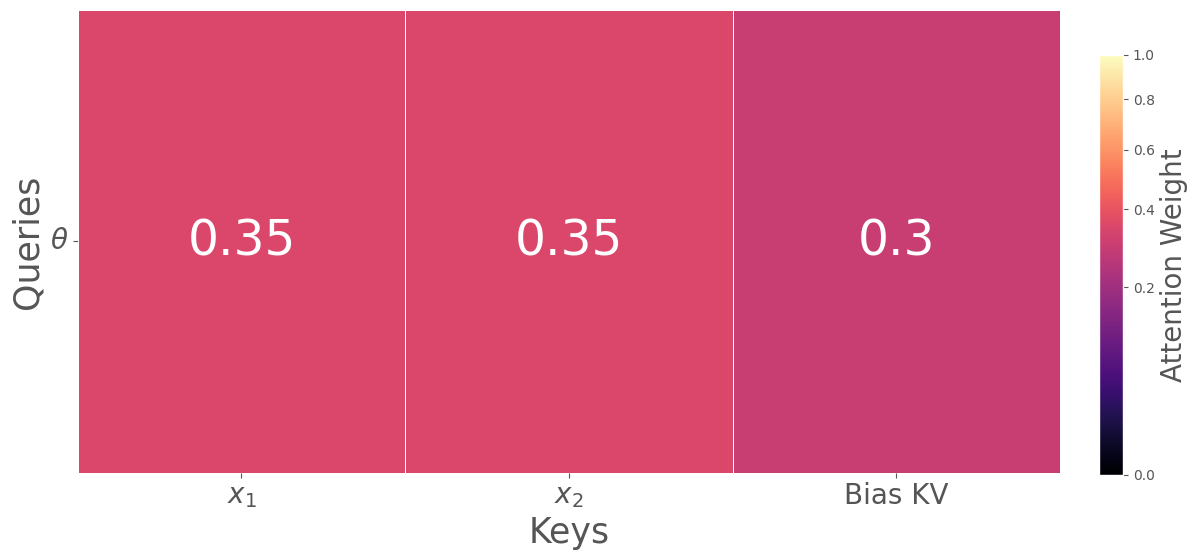

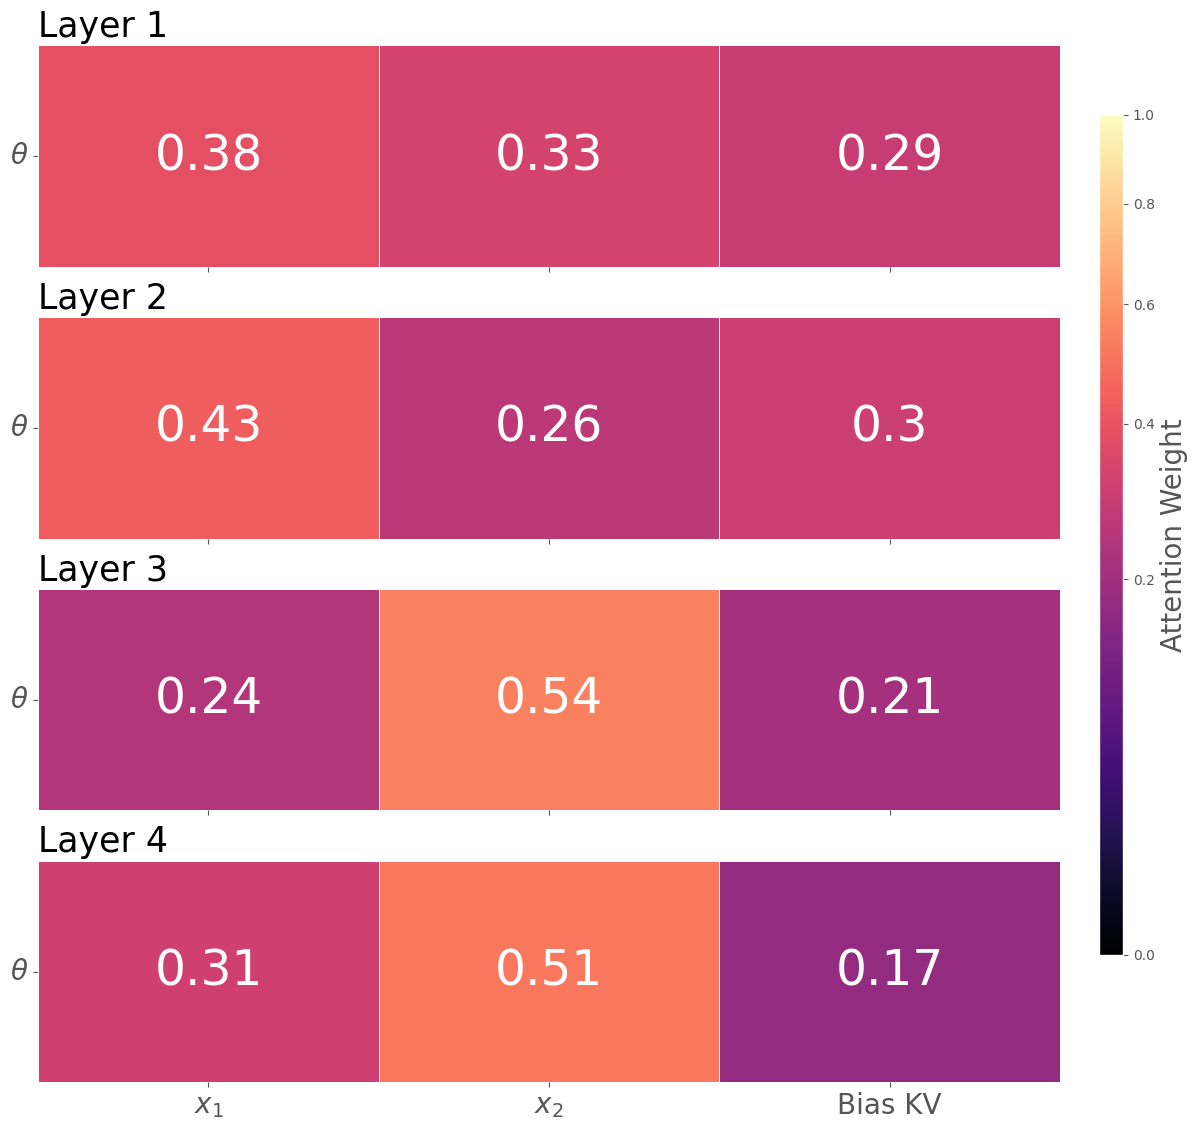

In [19]:
mtf.plot_attention(labels=[r"$\theta$", r"$x_1$", r"$x_2$"])

In [20]:
import pickle

with open("data/tutorial_Gaussians/model_comp.pkl", "rb") as f:
    results = pickle.load(f)

In [21]:
100*((test_theta1- results["Hypothesis 1"]["MAP"][:,0]).abs()/test_theta1.abs()).mean()

tensor(121.5668, dtype=torch.float64)

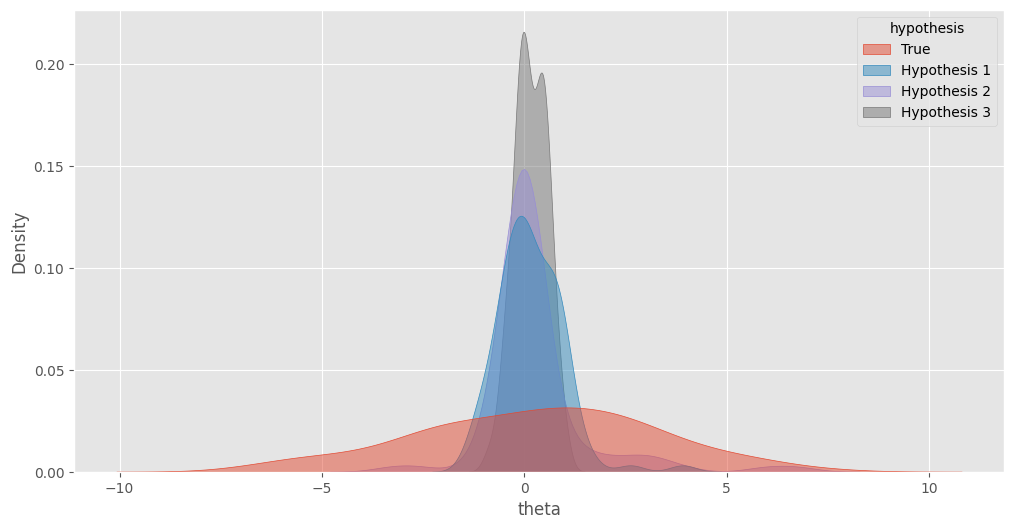

In [22]:
df_theta_test = pd.DataFrame(test_theta1.numpy(), columns=["theta"])
df_theta_test["hypothesis"] = "True"
df_theta1_hat = pd.DataFrame(results["Hypothesis 1"]["MAP"][:,0], columns=["theta"])
df_theta1_hat["hypothesis"] = "Hypothesis 1"
df_theta2_hat = pd.DataFrame(results["Hypothesis 2"]["MAP"][:,0], columns=["theta"])
df_theta2_hat["hypothesis"] = "Hypothesis 2"
df_theta3_hat = pd.DataFrame(results["Hypothesis 3"]["MAP"][:,0], columns=["theta"])
df_theta3_hat["hypothesis"] = "Hypothesis 3"

df_maps = pd.concat([df_theta_test, df_theta1_hat, df_theta2_hat, df_theta3_hat], axis=0)

plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df_maps, x="theta", hue="hypothesis", fill=True, alpha=0.5)
plt.show()